# Nelder-Mead algorithm

## Imports

In [1]:
%load_ext autoreload
%autoreload

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nelder_mead import NelderMeadOptimizer
from IPython.display import Image

sns.set(style="darkgrid", font_scale=1.4)

## Defining vectorized version of a function

Below is a vectorized version of a function (we would prefer a vectorized one because we care about the performance, don't we?)

In [2]:
def f(ts):
    """
    Function for optimization
    
    Args:
        ts: numpy array of shape (a, 2) -- arguments of a function
        
    Returns:
        numpy array of shape (a,) -- values of function at different points 
    """
    # Split the input data into x and y components for the sake of simplifying the code
    xs = ts[..., 0]
    ys = ts[..., 1]
    
    return np.sin(ys) * np.exp(np.square(1 - np.cos(xs))) + np.cos(xs) * np.exp(np.square(1 - np.sin(ys))) + np.square(xs - ys)


Let's plot our function

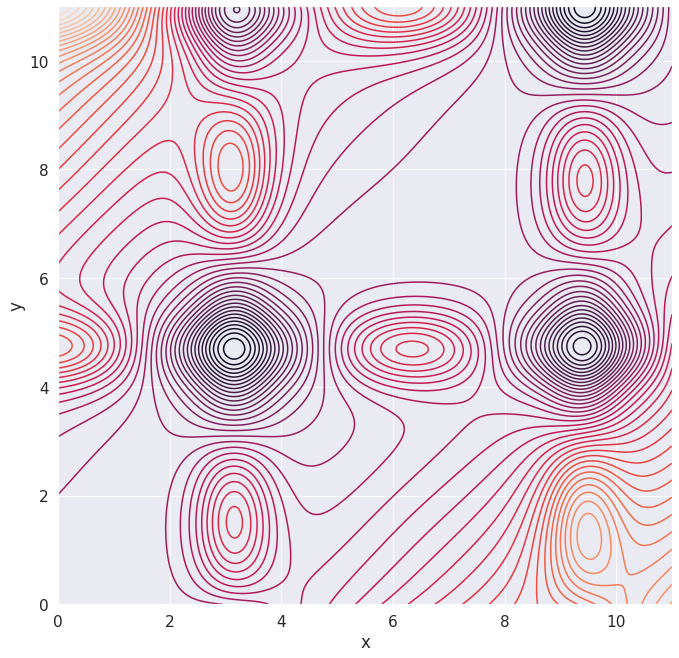

In [3]:
fr = 0
to = 11
step = 0.01
ts = np.mgrid[fr:(to + step):step, fr:(to+step):step].reshape(2,-1).T

xs = np.arange(fr, to + step, step)
ys = np.arange(fr, to + step, step)
size = xs.size
fs = f(ts).reshape((size,size)).T

plt.figure(figsize=(11, 11))
plt.xlabel("x")
plt.ylabel("y")
plt.contour(xs, ys, fs, levels=50)

Now, I imagine, we're finally ready to try out our shiny new optimizer. Let's run it:

In [4]:
opt = NelderMeadOptimizer(log_simplices=True)  # Enable logging to create a stunning plot of converging simplices 
                                               # later
    
initial_simplex = np.array([[0.0, 0.0],
                            [0.0, 11.0],
                            [11.0, 0.0]])
optimum = opt.minimize(f, initial_simplex, max_iterations=50, vartol=1e-4)
print("Optimal point seems to be", optimum)

Optimal point seems to be [3.14512039 4.6988869 ]


Now let's look at the way the simplices were converging:

In [5]:
fig = plt.figure(figsize=(11, 11), dpi=100)
ax = plt.axes(xlim=(0, 11), ylim=(0, 11))
plt.xlabel("x")
plt.ylabel("y")

cur_best = ax.scatter([], [], marker='*', color="lightseagreen", zorder=102, label="Current minimum estimation")
cur_path, = ax.plot([], [], color="lightseagreen", zorder=101, label="Path of the minimum estimations")
cur_simplex, = ax.plot([], [], color="black", zorder=100, label="Current simplex")
ax.contour(xs, ys, fs, levels=50)

simplices = np.array(opt.get_simplices_log())

def animate(i):
    i = min(i, len(opt.get_simplices_log()) - 1)

    simplex = simplices[i]
    simplex = np.append(simplex, [simplex[0]], axis=0)
    cur_path.set_data(simplices[:i, 0, 0], simplices[:i, 0, 1])
    cur_simplex.set_data(simplex[:, 0], simplex[:, 1])
    cur_best.set_offsets([simplex[0, 0], simplex[0, 1]])
    
    return cur_best, cur_simplex
    
anim = FuncAnimation(fig, animate, frames=len(opt.get_simplices_log()) + 30, interval=60, blit=True)
anim.save('opt.gif', writer='imagemagick')
plt.close()

And now let's have a look at the result of our suffering!

In [6]:
Image(url="opt.gif")

This is nice, but now we should provide an example of algorithm's convergence to two different points depending on the initial simplex

In [7]:
opt1 = NelderMeadOptimizer(log_simplices=True)
opt2 = NelderMeadOptimizer(log_simplices=True)
initial_simplex_1 = np.array([[0.0, 0.0],
                            [0.0, 11.0],
                            [11.0, 0.0]])
initial_simplex_2 = np.array([[11.0, 11.0],
                            [0.0, 11.0],
                            [11.0, 0.0]])
optimum1 = opt1.minimize(f, initial_simplex_1, vartol=1e-4)
optimum2 = opt2.minimize(f, initial_simplex_2, vartol=1e-4)
print("x_1 =", optimum1)
print("x_2 =", optimum2)

x_1 = [3.14512039 4.6988869 ]
x_2 = [9.39782591 4.75624243]


As we can see, the algoritm has converged to two different points depending on the initial simplex

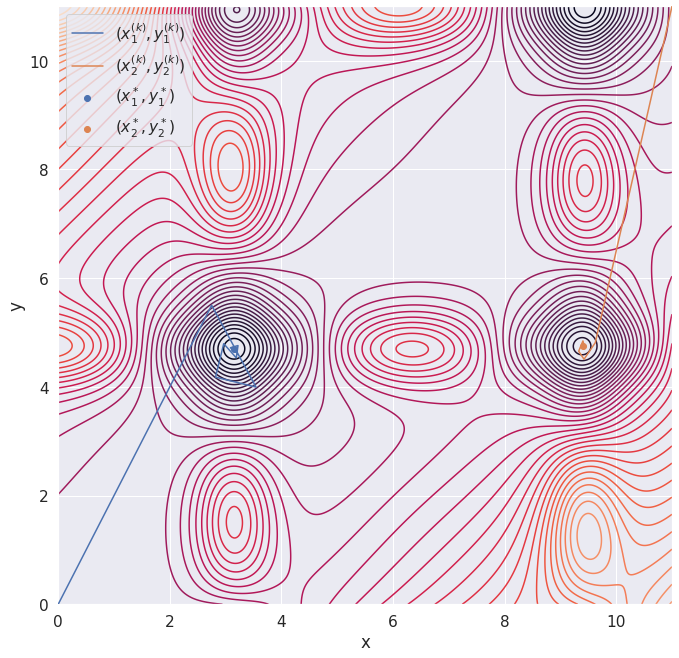

In [8]:
def get_best_points(simplices_list):
    simplices = np.array(simplices_list)
    bps_x = simplices[:, 0, 0]
    bps_y = simplices[:, 0, 1]
    return bps_x, bps_y

xs1, ys1 = get_best_points(opt1.get_simplices_log())
xs2, ys2 = get_best_points(opt2.get_simplices_log())
    
plt.figure(figsize=(11, 11))
plt.xlabel("x")
plt.ylabel("y")
plt.contour(xs, ys, fs, levels=50)
plt.scatter(optimum1[0], optimum1[1], label="$(x^*_1, y^*_1)$", zorder=102)
plt.scatter(optimum2[0], optimum2[1], label="$(x^*_2, y^*_2)$", zorder=102)
plt.plot(xs1, ys1, label="$(x_1^{(k)}, y_1^{(k)})$", zorder=101)
plt.plot(xs2, ys2, label="$(x_2^{(k)}, y_2^{(k)})$", zorder=101)
plt.legend()
plt.show()

Let's now show that changes to the parameters can affect convergence as well, even though the initial simplex remains unchanged.

In [9]:
initial_simplex = np.array([[0.0, 0.0],
                            [0.0, 11.0],
                            [11.0, 0.0]])

parameters = [
    (1.0, 2.0, 0.5, 0.5),
    (1.0, 2.0, 0.1, 0.5),
    (10.0, 2.0, 0.5, 0.5)
]

opts = list()
optimums = list()

for (alpha, gamma, rho, sigma) in parameters:
    opt = NelderMeadOptimizer(alpha=alpha, gamma=gamma, rho=rho, sigma=sigma, log_simplices=True)
    optimum = opt.minimize(f, initial_simplex, vartol=1e-4)
    
    opts.append(opt)
    optimums.append(optimum)
    
for i in range(len(optimums)):
    print("x_{} = {}".format(i + 1, optimums[i]))

x_1 = [3.14512039 4.6988869 ]
x_2 = [0.78300956 0.68250462]
x_3 = [2.4959278  4.89297192]


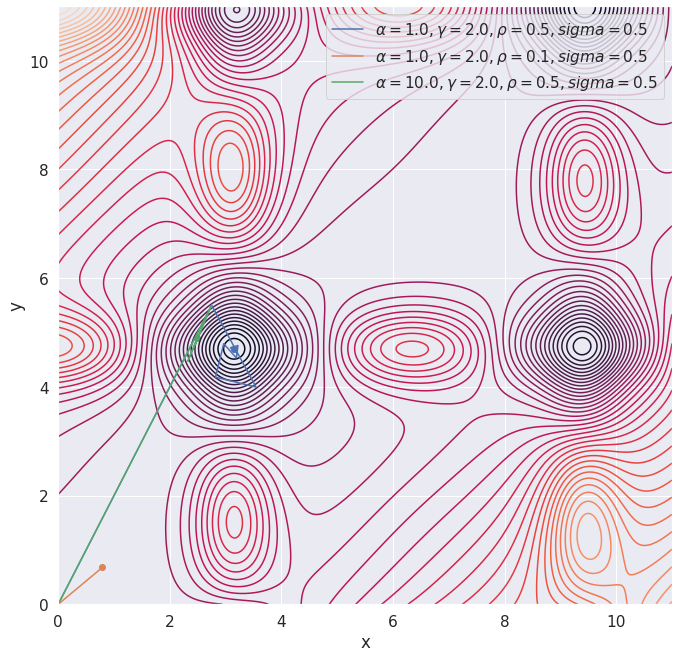

In [10]:
xs1, ys1 = get_best_points(opt1.get_simplices_log())
xs2, ys2 = get_best_points(opt2.get_simplices_log())
    
plt.figure(figsize=(11, 11))
plt.xlabel("x")
plt.ylabel("y")
plt.contour(xs, ys, fs, levels=50)
for i in range(len(parameters)):
    alpha, gamma, rho, sigma = parameters[i]
    opt = opts[i]
    optimum = optimums[i]
    xs_best, ys_best = get_best_points(opt.get_simplices_log())
    
    plt.plot(xs_best, ys_best, label=r"$\alpha = {}, \gamma = {}, \rho = {}, sigma = {}$".format(alpha, gamma, rho, sigma))
    plt.scatter(optimums[i][0], optimums[i][1])
    
plt.legend()
plt.show()

As we can see, hyperparameters do indeed affect convergence.

## Thank you for your attention!

Here is a photo of funny wolves to brighten up your day!

![funny_wolves.jpg](funny_wolves.jpg)